In [ ]:
"""
SINA CO-AUTHOR NETWORK GRAPH ANALYSIS 

Code for generating Nodes/Edgest list for Co-Authors from Dimensions Dataset

Source data: Dimensions Published Papers for Profession Zhang between 2011 and 2021

1. Load in Dimensions Data Set
2. Split out Co-Authors per Paper
   - Assign Author ID for unique Author by Name
3. Generate Node list of unique Authors
4. Generate Edges list for Co-Author pairs - all Co-Authors are linked to each other
   - links between Papers will be based on unique Author names
"""

In [17]:
# Load pandas
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns            
%matplotlib inline 
sns.set(color_codes=True)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, Normalizer, normalize

# regular expression package for removing punctuation from text
import re

# which folders host all the python files
import sys

In [4]:
#-----------------------------------------------------------------------------
# Load in the Citations data
#-----------------------------------------------------------------------------
# doc_dv = 'Dimensions-Publication-2021-03-15_09-30-48.csv'
doc_dv = 'Dimensions-Publication-2021-03-23_11-26-38.csv'

data = pd.read_csv('../csv-files/' + doc_dv, skiprows=1, low_memory=False)
print(data.info())

# cleanup unwanted rows & columns
df_data = data.copy()
print('n-rows    = ', len(df_data),'(before filtering)')

# exclude rows where ID not begin with 'pub.'
df_data = df_data[df_data['Publication ID'].str.contains('pub.') == True]

# remove most columns exception for 'Publication ID', 'Cited references'
n = len(df_data.columns)
print('n-columns = ',n)
print('n-rows    = ', len(df_data),'(after filtering)','\n')

# only keep meaningful columns - not "unamed"
df_data.drop(df_data.iloc[:, 15:n], inplace = True, axis = 1) 
print(df_data.columns.tolist(),'\n')

# clean up rows where Times Cited is not a number
df_data_fix = df_data.copy()
df_data['len_cited'] = [len(str(x)) for x in df_data['Times cited']]
print(df_data.head(3))

print('len(df_data)',len(df_data))
df_data = df_data.dropna(subset=['Times cited'])
print('len(df_data)',len(df_data))

df_data = df_data[df_data['len_cited']<=3]
# print(df_data)

# convert Times cited to number
df_data['Fix'] = [int(x) for x in df_data['Times cited']]
columns=['Times cited']
df_data.drop(columns,axis=1,inplace=True)

# rename fixed column, back to Times cited
df_data = df_data.rename(columns={'Fix':'Times cited'})
print(df_data.info())                    

# Extract only the useful dimensions
df_data = df_data[['Publication ID','Title','Abstract','Authors','Authors Affiliations - Name of Research organization','Times cited','Cited references']].copy()
df_data.columns = ['Publication ID','Title','Abstract','Authors','Authors Affiliations','Times Cited','Cited references']
df_data.head(3)

csv_file = 'Dimensions-Publication_small.csv'
df_data.to_csv('../csv-files/' + csv_file)
print('df_data                     ',df_data.shape)

#-----------------------------------------------------------------------------
# Extract out individual Authors, Affiliations, Cited references - from lists
#-----------------------------------------------------------------------------
# df_citat['Authors'][1]
# eg: 'Molin, Nicole L.; Molin, Clifford; Dalpatadu, Rohan J.; Singh, Ashok K.'

df_pub = df_data[['Publication ID','Authors','Authors Affiliations','Cited references','Times Cited']].copy()

df_pub.to_csv('df_published.csv')

# Replace NaN with a ';' - will delete these later stage
df_pub['Authors_2'] = df_pub['Authors'].fillna(';')
df_pub['Authors Affiliations_2'] = df_pub['Authors Affiliations'].fillna(';')
df_pub['Cited references_2'] = df_pub['Cited references'].fillna(';')
print('with additional fix columns ',df_pub.shape)
df_pub

# rename our fixed columns back to the original ones
df_pub = df_pub.drop(columns=(['Authors','Authors Affiliations','Cited references']))
df_pub.columns=(['Publication ID','Times Cited','Authors','Authors Affiliations','Cited references'])
print('after fix columns removed   ',df_pub.shape)

# Remove junk author to avoid count/sorting fail
pub_list = ['pub.1134802587','pub.1134588066']
df_pub[~df_pub['Publication ID'].isin(pub_list)]

# some test publications during development
pub_list_in = ['pub.1129598070','pub.1129601032','pub.1135906085','pub.1136271880']
#df_pub = df_pub[df_pub['Publication ID'].isin(pub_list_in)]

# extract sample rows for development only
sample_rows=5000
df_pub = df_pub[0:sample_rows]
print('test rows during development',df_pub.shape)

df_pub = df_pub.reset_index()
df_pub

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 15 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Publication ID                                           437 non-null    object
 1   DOI                                                      436 non-null    object
 2   Title                                                    437 non-null    object
 3   Abstract                                                 429 non-null    object
 4   Source title/Anthology title                             399 non-null    object
 5   PubYear                                                  437 non-null    int64 
 6   Volume                                                   303 non-null    object
 7   Issue                                                    210 non-null    object
 8   Pagination                              

,index,Publication ID,Times Cited,Authors,Authors Affiliations,Cited references
0,0,pub.1130066095,0,"Choi, Jeongsub; Kim, Byunghoon; Han, Chang Hee...",West Virginia University; Hanyang University; ...,"[Hottenrott, Hanna; Lopes-Bento, Cindy]|[ur.01..."
1,1,pub.1135109911,0,"Roozbahani, Zahra; Rezaeenour, Jalal; Shahrooe...",University of Qom; Yazd University,"[Kong, Xiangjie; Jiang, Huizhen; Yang, Zhuo; X..."
2,2,pub.1134588294,0,"Sassen, Catherine; Brannon, Sian",University of North Texas,"[Metz, Paul]|[]|College & Research Libraries|1..."
3,3,pub.1134424642,0,"Schvaneveldt, Nena; Stellrecht, Elizabeth M","University of Utah; University at Buffalo, Sta...","[Beverley, C. A.; Booth, A.; Bath, P. A.]|[ur...."
4,4,pub.1133872447,0,;,;,;
...,...,...,...,...,...,...
432,432,pub.1022090642,31,;,;,;
433,433,pub.1028699967,0,"Carvey, Harlan",;,;
434,434,pub.1036193461,2,;,;,;
435,435,pub.1102326243,20,"Ulrich, Karl T.",;,"[Hotelling, Harold]|[]|The Economic Journal|19..."


In [5]:
#----------------------------------------------------
# Extract individual strings from list - Authors
#----------------------------------------------------
df_pub['Authors_Split'] = [list(x.split('; ')) for x in df_pub['Authors']]
df_pub.head()

# df_test['Authors_Split'].iloc[2]
df_split = df_pub[['index','Publication ID','Times Cited','Authors_Split']].copy()
df_split

# how many co-authors for each paper
df_split['# Authors'] = [len(x) for x in df_split['Authors_Split']]
df_split.sort_values('# Authors', ascending=False)
df_split

# Dataframe just of Pub-ID with Index 0-N rows
df_paper = pd.DataFrame(df_split.iloc[:,:5])   #.values.tolist())  #.reset_index()
# temp name for index column
df_paper['index_pub'] = df_paper['index']
df_paper = df_paper[['index','index_pub','Publication ID','Times Cited','Authors_Split','# Authors']]
df_paper

# Dataframe just of Authors but converted to columns (across)
df_auth = df_split[['index','Authors_Split']].copy()
df_auth_cols = df_auth.iloc[:,1].apply(pd.Series).reset_index()  
df_auth_cols

# Concat (join) dataframes based on Index (hopefully they match original Pub-ID and Author rows)
df_new = pd.concat([df_paper, df_auth_cols], axis=1)
df_new = df_new.fillna('')

# remove both index columns
df_new.drop(df_new.iloc[:,:1], inplace = True, axis = 1)
df_new = df_new.rename(columns={'index_pub':'index'})
df_new

,index,Publication ID,Times Cited,Authors_Split,# Authors,0,1,2,3,4,...,7,8,9,10,11,12,13,14,15,16
0,0,pub.1130066095,0,"[Choi, Jeongsub, Kim, Byunghoon, Han, Chang He...",7,"Choi, Jeongsub","Kim, Byunghoon","Han, Chang Hee","Hahn, Hyuk","Park, Hun",...,,,,,,,,,,
1,1,pub.1135109911,0,"[Roozbahani, Zahra, Rezaeenour, Jalal, Shahroo...",4,"Roozbahani, Zahra","Rezaeenour, Jalal","Shahrooei, Roshan","Emamgholizadeh, Hanif",,...,,,,,,,,,,
2,2,pub.1134588294,0,"[Sassen, Catherine, Brannon, Sian]",2,"Sassen, Catherine","Brannon, Sian",,,,...,,,,,,,,,,
3,3,pub.1134424642,0,"[Schvaneveldt, Nena, Stellrecht, Elizabeth M]",2,"Schvaneveldt, Nena","Stellrecht, Elizabeth M",,,,...,,,,,,,,,,
4,4,pub.1133872447,0,[;],1,;,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,432,pub.1022090642,31,[;],1,;,,,,,...,,,,,,,,,,
433,433,pub.1028699967,0,"[Carvey, Harlan]",1,"Carvey, Harlan",,,,,...,,,,,,,,,,
434,434,pub.1036193461,2,[;],1,;,,,,,...,,,,,,,,,,
435,435,pub.1102326243,20,"[Ulrich, Karl T.]",1,"Ulrich, Karl T.",,,,,...,,,,,,,,,,


In [26]:
#------------------------------------------------------
# iterate across all author columns, append them after each other, final concat for all appended dataframes
#------------------------------------------------------
# create Pub-ID column name so can link back to original data
col_list = list(df_new.columns.values)
col_list

print('authors col_list = ',col_list[5],'-',col_list[len(col_list)-1])
col_end = col_list[len(col_list)-1]

# iterate across all author columns
all_auth = []
new_list = ['index','Publication ID','Times Cited','Authors_Split','# Authors','Author']
for col in col_list[5:]:
    df_app = []
    df_app = df_new[['index','Publication ID','Times Cited','Authors_Split','# Authors',col]].copy()
    df_app.columns = new_list
    all_auth.append(df_app)

# concatenated all appended Author (wide) columns into 1 single column
df_pub_auth = pd.concat(all_auth)
print('len pub-auth all rows         ',df_pub_auth.shape)

# remove rows with blank Authors
df_pub_auth = df_pub_auth[df_pub_auth['Author']!='']  
df_pub_auth = df_pub_auth[df_pub_auth['Author']!=';']  
print('len pub-auth del blank Authors',df_pub_auth.shape)

# save output Published Papers - each Author linked to paper
df_pub_auth.to_csv('df_pub_authors.csv')
df_pub_auth

authors col_list =  0 - 16
len pub-auth all rows          (7429, 6)
len pub-auth del blank Authors (1248, 6)


,index,Publication ID,Times Cited,Authors_Split,# Authors,Author
0,0,pub.1130066095,0,"[Choi, Jeongsub, Kim, Byunghoon, Han, Chang He...",7,"Choi, Jeongsub"
1,1,pub.1135109911,0,"[Roozbahani, Zahra, Rezaeenour, Jalal, Shahroo...",4,"Roozbahani, Zahra"
2,2,pub.1134588294,0,"[Sassen, Catherine, Brannon, Sian]",2,"Sassen, Catherine"
3,3,pub.1134424642,0,"[Schvaneveldt, Nena, Stellrecht, Elizabeth M]",2,"Schvaneveldt, Nena"
7,7,pub.1135675310,0,"[Garces, Edwin, Daim, Tugrul U., Dabic, Marina]",3,"Garces, Edwin"
...,...,...,...,...,...,...
122,122,pub.1105213644,6,"[Araguz, Carles, Llaveria, David, Lancheros, E...",17,"Rodríauez, Pedro"
74,74,pub.1120772591,1,"[Lazcano, Raquel, Madroñal, Daniel, Florimbi, ...",15,"Sanz, Cesar"
122,122,pub.1105213644,6,"[Araguz, Carles, Llaveria, David, Lancheros, E...",17,"Alvaro, Angel"
122,122,pub.1105213644,6,"[Araguz, Carles, Llaveria, David, Lancheros, E...",17,"Sochacki, Mateusz"


In [11]:
#-----------------------------------------------------------
# create "Paper" Author nodes - assume Author with same name
# is the same Author - may not be true in real life
#-----------------------------------------------------------

df_node_author = df_pub_auth.copy()
df_node_author = df_node_author[['index','Author']].groupby('Author').count().reset_index().reset_index()
df_node_author.columns=(['index_author','Author','Author Count Times'])
df_node_author

# combine Published-Author + Author-ID to link Paper-ID and Author-ID
df_pub_auth_2 = df_pub_auth.join(df_node_author.set_index('Author'), on='Author')
df_pub_auth_2

#-------------------------------------------------------
# finish creating nodes for each Author (unique by name)
df_node_author['node_group']='paper'
df_node_author.columns=(['node_id','node_name','size_author','node_group'])
df_node_author

#-------------------------------------------------------
# check rows are the same - start of Pub list, end of Author list - matching above lists
nodes = df_node_author[['node_id','node_name','node_group','size_author']]

nodes.sort_values('size_author', ascending=False).head(5)

,node_id,node_name,node_group,size_author
456,456,"Kim, Jinseok",paper,11
212,212,"Diesner, Jana",paper,9
996,996,"Wang, Wei",paper,5
134,134,"Chen, Hung-Hsuan",paper,5
1058,1058,"Yu, Philip S.",paper,3


df_p:      node_id                    node_name node_group  size_author
456      456                 Kim, Jinseok      paper           11
212      212                Diesner, Jana      paper            9
134      134             Chen, Hung-Hsuan      paper            5
996      996                    Wang, Wei      paper            5
819      819  Saoud, Narjès Bellamine Ben      paper            3


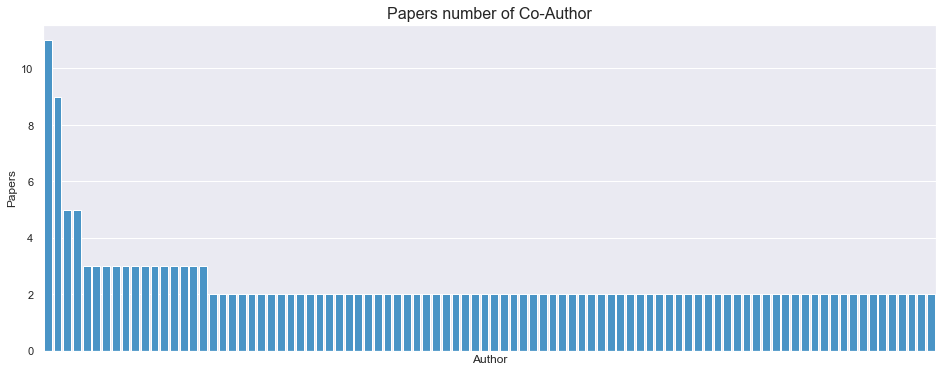

In [12]:
#-----------------------------------------------------------------
# Visualise number of co-authors per paper - limit number of papers for graph
#-----------------------------------------------------------------

#df_p = pd.DataFrame(df_auth.pivot_table(index=['Author'], aggfunc='size')).reset_index().reset_index()
#df_p.columns = ['index','Author','count']

x_lab = 'node_id'
y_lab = 'size_author'
size_min = 2
clrs = ['#3498db'] 

df_p = nodes.copy()
df_p = df_p[df_p[y_lab]>=size_min].sort_values('size_author', ascending=False)
print('df_p:',df_p.sort_values('size_author', ascending=False).head(5))

fig = plt.figure(figsize=(16, 6))   
ax = sns.barplot(data=df_p, x=x_lab, y=y_lab, order=df_p[x_lab], palette=sns.color_palette(clrs, 10))

#ax.set(ylim=(0, 125))
ax.set_title('Papers number of Co-Author', fontsize=16)
plt.xlabel('Author')
plt.ylabel('Papers')
plt.rcParams["figure.figsize"] = (10,3)
plt.xticks(rotation='vertical')
plt.xticks([])
#plt.yticks([])
plt.show();

## Create Co-Author Relationships for Network Graph
Each Co-Author of a Paper is linked to each other - like a Clique (sub-network)

In [20]:
# data for Published Paper ID linked to Co-Author ID's
df_pub_auth_2

,index,Publication ID,Times Cited,Authors_Split,# Authors,Author,index_author,Author Count Times
0,0,pub.1130066095,0,"[Choi, Jeongsub, Kim, Byunghoon, Han, Chang He...",7,"Choi, Jeongsub",154,1
1,1,pub.1135109911,0,"[Roozbahani, Zahra, Rezaeenour, Jalal, Shahroo...",4,"Roozbahani, Zahra",793,2
2,2,pub.1134588294,0,"[Sassen, Catherine, Brannon, Sian]",2,"Sassen, Catherine",823,1
3,3,pub.1134424642,0,"[Schvaneveldt, Nena, Stellrecht, Elizabeth M]",2,"Schvaneveldt, Nena",831,1
7,7,pub.1135675310,0,"[Garces, Edwin, Daim, Tugrul U., Dabic, Marina]",3,"Garces, Edwin",288,2
...,...,...,...,...,...,...,...,...
122,122,pub.1105213644,6,"[Araguz, Carles, Llaveria, David, Lancheros, E...",17,"Rodríauez, Pedro",787,1
74,74,pub.1120772591,1,"[Lazcano, Raquel, Madroñal, Daniel, Florimbi, ...",15,"Sanz, Cesar",817,1
122,122,pub.1105213644,6,"[Araguz, Carles, Llaveria, David, Lancheros, E...",17,"Alvaro, Angel",19,1
122,122,pub.1105213644,6,"[Araguz, Carles, Llaveria, David, Lancheros, E...",17,"Sochacki, Mateusz",864,1


In [28]:
#--------------------------------------------------------------------------
# following code inspired by DVN week 8 lab - Song Similarity Network Graph
#--------------------------------------------------------------------------
# Get all unique Publication ID's
# df_test = df_pub_auth_2[['index','author_id']].copy()
pub_list = df_pub_auth_2['index'].unique().tolist()
print('Publication index list',pub_list)
print('# of Publications     ',len(pub_list),'\n')

# Subsetting
def subtable(df, productName):
    return (df[(df['index'] == productName)])

all_pairs = []
df_pairs = []

for pub in pub_list:
    auth_pairs = []
    df_subset = subtable(df_test, pub)
    # create indicies for each co-author in paper
    auth_indicies = df_subset['index_author'].values.tolist()
    # link all co-author indicies as pairs to each other
    auth_pairs = pd.DataFrame(list(itertools.combinations(auth_indicies, 2)))
    print('Publication ID',pub,', co-author pairs =', len(auth_pairs)) #, '\n', auth_pairs,'\n')
    all_pairs.append(auth_pairs)
    df_pairs = pd.concat(all_pairs)

# set a default edge weight for now - TBC solution for edges
df_pairs['weight'] = 1

print('\nFinal pairs co-authors for each Published Paper')
df_pairs.columns = ['author-1','author-2','weight']
df_pairs

Publication index list [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 141, 142, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 233, 23

Publication ID 209 , co-author pairs = 6
Publication ID 210 , co-author pairs = 21
Publication ID 211 , co-author pairs = 15
Publication ID 212 , co-author pairs = 3
Publication ID 213 , co-author pairs = 3
Publication ID 214 , co-author pairs = 6
Publication ID 215 , co-author pairs = 21
Publication ID 216 , co-author pairs = 3
Publication ID 217 , co-author pairs = 3
Publication ID 218 , co-author pairs = 3
Publication ID 219 , co-author pairs = 21
Publication ID 220 , co-author pairs = 1
Publication ID 221 , co-author pairs = 10
Publication ID 222 , co-author pairs = 0
Publication ID 223 , co-author pairs = 1
Publication ID 224 , co-author pairs = 6
Publication ID 225 , co-author pairs = 6
Publication ID 226 , co-author pairs = 0
Publication ID 227 , co-author pairs = 6
Publication ID 228 , co-author pairs = 10
Publication ID 229 , co-author pairs = 1
Publication ID 230 , co-author pairs = 0
Publication ID 232 , co-author pairs = 0
Publication ID 233 , co-author pairs = 0
Publicatio

,author-1,author-2,weight
0,154,452,1
1,154,344,1
2,154,341,1
3,154,706,1
4,154,1054,1
...,...,...,...
13,460,638,1
14,667,638,1
0,108,504,1
1,108,1068,1


In [29]:
#--------------------------------------------------------------------------
# output nodes & edges for import to Network Graph Analysis tools
#--------------------------------------------------------------------------
nodes.to_csv('coauthor_nodes.csv', index=0)

df_pairs.to_csv('coauthor_edges.csv', index=0)

node rows: 1121


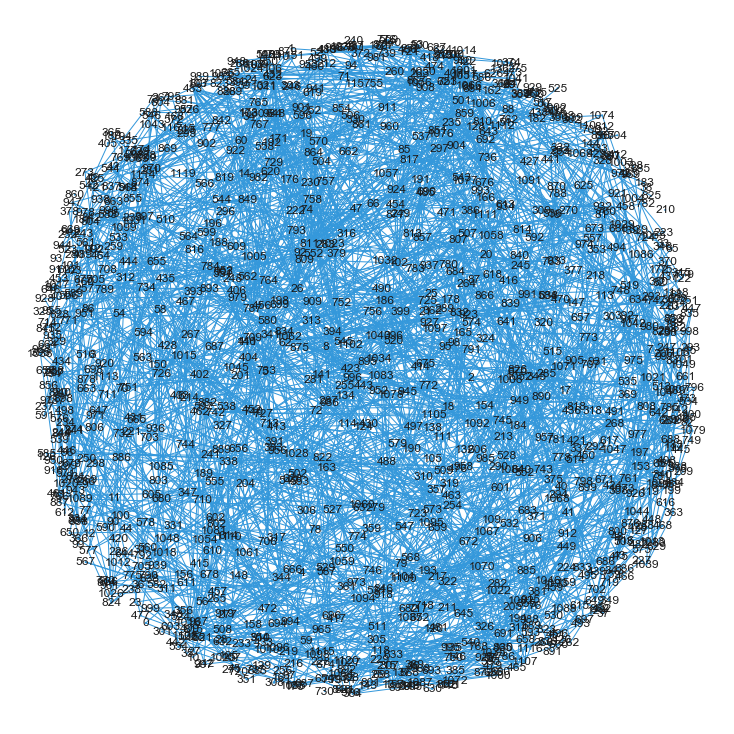

In [24]:
#--------------------------------------------------------------------------
# Visualise Co-Authors of Published Papers linked by Author ID (unique Name)
# Basic graph version to help understand data, not interactive
#--------------------------------------------------------------------------
clr_edge = '#3498DB'

G = nx.Graph()  

i=0
for index, row in df_node_author.iterrows():
    #G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    G.add_node(row['node_id'], nodesize=row['size_author'])
    i=i+1

for index, row in df_pairs.iterrows():
    #G.add_weighted_edges_from([(row['source'], row['target'], row['weight'])])
    G.add_edges_from([(row['author-1'], row['author-2'])])

print('node rows:',i)

plt.figure(figsize=(10,10))
options = {
    'edge_color': clr_edge,
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}

#colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]
sizes = [G.nodes[n]['nodesize']*1 if len(G.nodes[n].keys())>0 else 1 for n in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
- default k=0.1 and iterations=50

nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
"""

nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=0.5, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#3498DB") 
plt.show()